In [1]:
%matplotlib inline
import os
import math
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from functools import partial

from pandas.plotting import scatter_matrix

from sklearn.externals import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor;

F:\ML\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
TAXIFARE_PATH = os.path.join("../datasets", "NYCityTaxiFare")
FILE_NAME = "train.csv"
SIZE_CHUNK = 1*(10**6) #размер пакета данных в миллионах образцов
R = 6371 #радиус Земли для вычисления растояния

In [3]:
#выбор N рандомных мини-пакетов для обучения нейронной сети
def random_batch(X_train, y_train, batch_size):
    rnd_index = np.random.randint(0, len(X_train), batch_size) # создаем случайные индексы строк
    X_batch = X_train[rnd_index, :]
    y_batch = y_train.values[rnd_index]
    return X_batch, y_batch

In [4]:
def load_taxifare_data(taxifare_path=TAXIFARE_PATH, file_name = FILE_NAME, size_chunk = SIZE_CHUNK):
    csv_path = os.path.join(taxifare_path, file_name)
    return pd.read_csv(csv_path, nrows = size_chunk)

In [5]:
#подсчет ошибки конкретной модели
def rmse(estimator, data_set, lables):
    lables_pred = estimator.predict(data_set)
    mse = mean_squared_error(lables, lables_pred)
    rmse = np.sqrt(mse)
    return rmse

In [6]:
#Подсчет прямого расстояния между точками отбытия и прибытия (https://en.wikipedia.org/wiki/Haversine_formula)
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) #переводим координаты(градусы) в радианы

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    temp = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    d = 2 * np.arcsin(np.sqrt(temp))
    d_km = R * d #получаем расстояние в километрах
    
    return d_km

In [7]:
# удаление координат лежащих на воде
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # рамка ограничения
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # преобразование карты в массив булевых значений
    # Земля = True, Вода = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    

    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    return df[idx]

In [8]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [9]:
taxifare_load = load_taxifare_data()

In [10]:
taxifare = taxifare_load.copy()

# Обработка данных

## Удалим выбросы из загруженых данных

### 1) 6 человек это максимум который поместится в минивэн

In [11]:
taxifare = taxifare.loc[taxifare["passenger_count"].between(1, 6)]

### 2) стоимость ограничим от 2.5(стомость посадки) до 100(см. график)

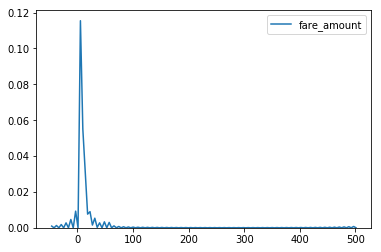

In [12]:
sns.kdeplot(taxifare["fare_amount"])

In [13]:
taxifare = taxifare.loc[taxifare["fare_amount"].between(2.5, 100)]

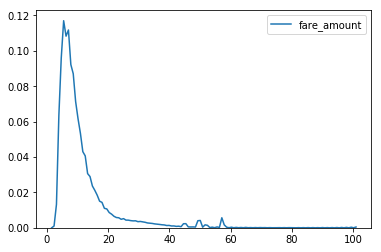

In [14]:
sns.kdeplot(taxifare["fare_amount"])

### выше можно заметить пики между 40-60. Это поездки в аэропорты. В NY их три ~40, ~50, ~60 соотвественно

### 3) координаты ограничим согласно координатам NY и графикам, после удалим точки лежащие на воде

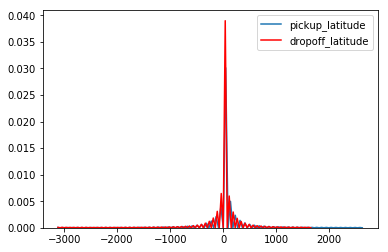

In [15]:
sns.kdeplot(taxifare["pickup_latitude"])
sns.kdeplot(taxifare["dropoff_latitude"], color="red")

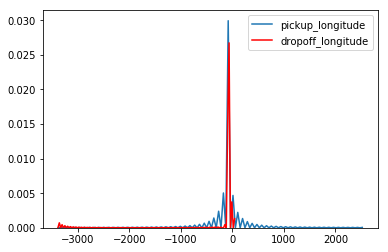

In [16]:
sns.kdeplot(taxifare["pickup_longitude"])
sns.kdeplot(taxifare["dropoff_longitude"], color="red")

In [17]:
taxifare = taxifare.loc[taxifare["pickup_longitude"].between(-74.5, -72.8)]
taxifare = taxifare.loc[taxifare["dropoff_longitude"].between(-74.5, -72.8)]

In [18]:
taxifare = taxifare.loc[taxifare["pickup_latitude"].between(40.5, 41.8)]
taxifare = taxifare.loc[taxifare["dropoff_latitude"].between(40.5, 41.8)]

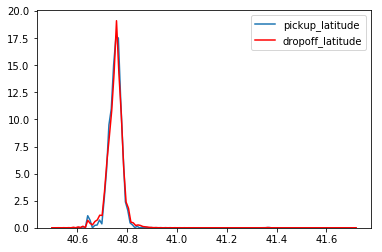

In [19]:
sns.kdeplot(taxifare["pickup_latitude"])
sns.kdeplot(taxifare["dropoff_latitude"], color="red")

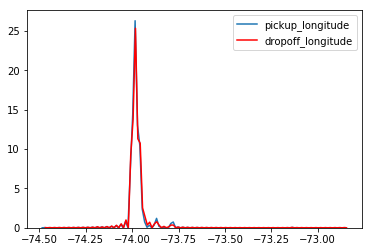

In [20]:
sns.kdeplot(taxifare["pickup_longitude"])
sns.kdeplot(taxifare["dropoff_longitude"], color="red")

In [21]:
print('Исходный размер набора: %d' % len(taxifare))
taxifare = remove_datapoints_from_water(taxifare)
print('Размер набора после удаления: %d' % len(taxifare))

Исходный размер набора: 975165
Размер набора после удаления: 974978


### 4) Теперь мы можем подсчитать прямое расстояние между точками в колометрах
### Можно также использовать API GoogleMaps и получить более точные расстояния по дорогам, но это будет очень дорого стоить

https://en.wikipedia.org/wiki/Haversine_formula

In [22]:
taxifare["distance_km"] = haversine_np(taxifare['pickup_longitude'], taxifare['pickup_latitude'],
                         taxifare['dropoff_longitude'], taxifare['dropoff_latitude'])

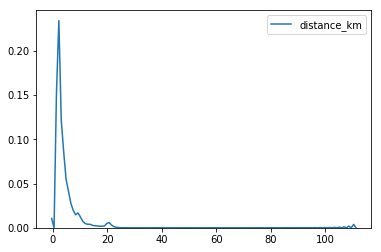

In [23]:
sns.kdeplot(taxifare["distance_km"])

### удалим поездки дальше 40км и меньше 300м. Также выше можно заметить поездки в аэропорты длиной 20км, но основной объем поездок это короткие 4-6км

In [24]:
taxifare = taxifare.loc[taxifare["distance_km"].between(0.3, 40)]

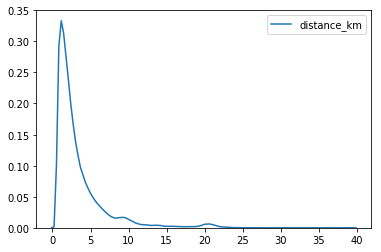

In [25]:
sns.kdeplot(taxifare["distance_km"])

### 5) Подсчитаем евклидово расстояние между координатми, а также так называемое расстояние городских кварталов или манхэттенсое расстояние(в нашем случае очень удобное)


https://ru.wikipedia.org/wiki/Расстояние_Минковского

https://ru.wikipedia.org/wiki/Евклидова_метрика

https://ru.wikipedia.org/wiki/Расстояние_городских_кварталов

In [26]:
taxifare["manhattan"] = minkowski_distance(taxifare["pickup_longitude"], taxifare["dropoff_longitude"],
                                       taxifare["pickup_latitude"], taxifare["dropoff_latitude"], 1)

taxifare["euclidean"] = minkowski_distance(taxifare["pickup_longitude"], taxifare["dropoff_longitude"],
                                       taxifare["pickup_latitude"], taxifare["dropoff_latitude"], 2)

## Построим график кореляции цены от различных признаков

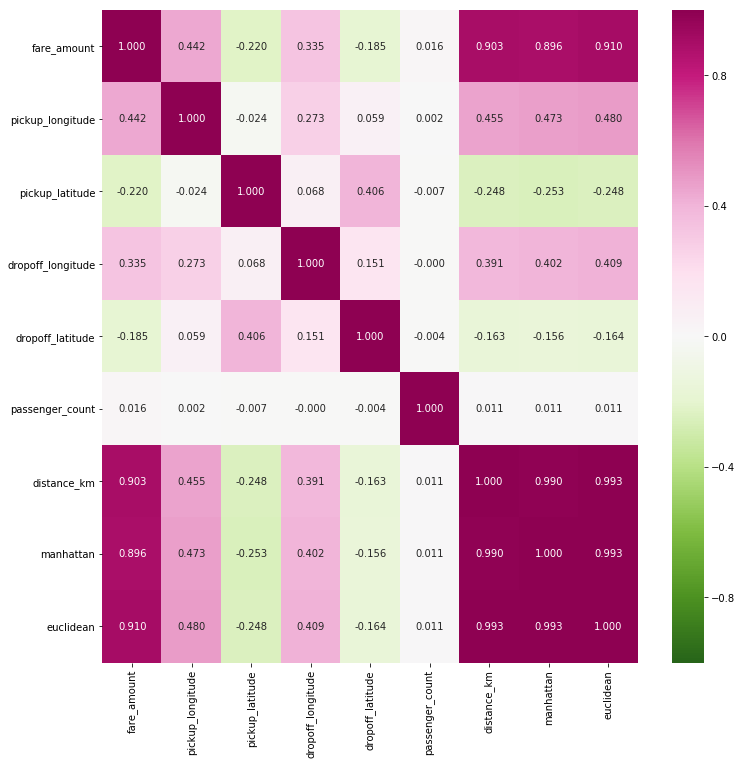

In [27]:
corrs = taxifare.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r)

### самые большие зависимости наблюдаются от дистанции в километрах, манхэттенского и евклидова расстояний
### Интресный вывод это высокие кореляции с долготой точки отбытия и прибытия, с другой стороный это логично, на юго-востоке Нью-Йорка находится его(и США) самый крупный аэропрот им. Кеннеди

## Выберем для начала только три признака с наиболие высокими кореляциями

In [28]:
columns = ["distance_km", "euclidean", "manhattan"]

#"key", "pickup_datetime", "pickup_latitude", "dropoff_latitude"
#"dropoff_longitude", "pickup_longitude", "abs_lat_diff", "abs_lon_diff", "euclidean", "manhattan"


In [29]:
X = taxifare[columns]
y = taxifare["fare_amount"]

### Проведем масштабирование входных признаков, после чего разделим данные на тренировачный и проверочный наборы

In [30]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

In [31]:
X = scaler.fit_transform(X)

In [32]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size = 20000, random_state = 42)

# Обучение моделей

## Выберем несколько моделей и запустим их без регуляризации

In [33]:
gradientboost_reg = GradientBoostingRegressor(random_state = 42, presort=False)

kneighbors_reg = KNeighborsRegressor(n_jobs=-1)

forest_reg = RandomForestRegressor(random_state = 42, n_jobs=-1)

extratree_reg = ExtraTreesRegressor(random_state = 42, n_jobs=-1)

adaboost_reg = AdaBoostRegressor(random_state = 42)

In [34]:
estimators = [gradientboost_reg, kneighbors_reg, forest_reg, extratree_reg, adaboost_reg]

for estimator in estimators:
    print("\nМодель", estimator)
    estimator.fit(X_train, y_train)


Модель GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort=False, random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Модель KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

Модель RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0

In [35]:
for estimator in estimators:
    print("\nМодель", estimator)
    print("RMSE train:", rmse(estimator, X_train, y_train))
    print("RMSE test:", rmse(estimator, X_val, y_val))


Модель GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort=False, random_state=42,
             subsample=1.0, verbose=0, warm_start=False)
RMSE train: 3.7151865303712994
RMSE test: 3.6996670333844706

Модель KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
RMSE train: 3.267631803336127
RMSE test: 4.013659729274518

Модель RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
   

## Хорошие результаты показали все модели кроме адаптивного бустинга

## Воспользуемся рандомизированым поиском для выявления лучших парамтров моделей

In [36]:
param_dist_kn={
            "n_neighbors": [5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85, 95, 110, 120, 130],
            "weights": ["uniform", "distance"]
           }
random_search_kn = RandomizedSearchCV(kneighbors_reg, param_dist_kn, n_iter=30, cv=5, verbose=5, 
                                      n_jobs = -1, error_score = 'neg_mean_squared_error')


param_dist_gb={
            "max_depth": [5, 10, 15, 20, 30, 40, 50],
            "n_estimators": [50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
            "loss": ['ls', 'lad', 'huber', 'quantile'],
            "max_features": [1, 2, 3],
            "max_leaf_nodes": [20, 40, 60, 80, 100, 120, 140, 160],
            "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 3, 9, 27, 81],
            "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
           }
random_search_gb = RandomizedSearchCV(gradientboost_reg, param_dist_gb, n_iter=100, cv=5, verbose=5, 
                                      n_jobs = -1, error_score = 'neg_mean_squared_error')

 
param_dist_forest={
            "max_depth": [5, 10, 15, 20, 30, 40, 50],
            "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            "max_leaf_nodes": [20, 40, 60, 80, 100, 120, 140, 160],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 3, 9, 27, 81]
           }
random_search_forest = RandomizedSearchCV(forest_reg, param_dist_forest, n_iter=100, cv=5, verbose=5, 
                                      n_jobs = -1, error_score = 'neg_mean_squared_error')


param_dist_extrtree={
            "max_depth": [5, 10, 15, 20, 30, 40, 50],
            "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            "max_leaf_nodes": [20, 40, 60, 80, 100, 120, 140, 160],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "max_features": [1, 2, 3],
            "min_samples_leaf": [1, 3, 9, 27, 81]
           }
random_search_extrtree = RandomizedSearchCV(extratree_reg, param_dist_extrtree, n_iter=100, cv=5, verbose=5, 
                                      n_jobs = -1, error_score = 'neg_mean_squared_error')

In [37]:
rand_seach_estimators = [random_search_kn, random_search_extrtree, random_search_forest, random_search_gb]

In [38]:
for estimator in rand_seach_estimators:
    print("\nМодель", estimator)
    estimator.fit(X_train, y_train)


Модель RandomizedSearchCV(cv=5, error_score='neg_mean_squared_error',
          estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85, 95, 110, 120, 130], 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.3min finished



Модель RandomizedSearchCV(cv=5, error_score='neg_mean_squared_error',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
          oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [5, 10, 15, 20, 30, 40, 50], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_leaf_nodes': [20, 40, 60, 80, 100, 120, 140, 160], 'min_samples_split': [2, 4, 8, 16, 32, 64], 'max_features': [1, 2, 3], 'min_samples_leaf': [1, 3, 9, 27, 81]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)
Fitting 5 folds for each of 100 candidates, t

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 61.0min finished



Модель RandomizedSearchCV(cv=5, error_score='neg_mean_squared_error',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [5, 10, 15, 20, 30, 40, 50], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_leaf_nodes': [20, 40, 60, 80, 100, 120, 140, 160], 'min_samples_split': [2, 4, 8, 16, 32, 64], 'min_samples_leaf': [1, 3, 9, 27, 81]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 102.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 184.1min finished



Модель RandomizedSearchCV(cv=5, error_score='neg_mean_squared_error',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort=False, random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [5, 10, 15, 20, 30, 40, 50], 'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 'loss': ['ls', 'lad', 'huber', 'quantile'], 'max_features': [1, 2, 3], 'max_leaf_nodes': [20, 40, 60, 80, 100, 120, 140, 160], 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 'min_samples_split': [2, 4, 8, 16, 32, 64], 'min_samples_leaf': [1, 3, 9, 27, 81], 'su

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 129.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 238.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 417.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 479.7min finished


In [39]:
for estimator in rand_seach_estimators:
    print("\nМодель", estimator.best_estimator_)
    print("RMSE train:", rmse(estimator.best_estimator_, X_train, y_train))
    print("RMSE test:", rmse(estimator.best_estimator_, X_val, y_val))


Модель KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=130, p=2,
          weights='uniform')
RMSE train: 3.6475581783481466
RMSE test: 3.676682759852601

Модель ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=20,
          max_features=3, max_leaf_nodes=160, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=8,
          min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
          oob_score=False, random_state=42, verbose=0, warm_start=False)
RMSE train: 3.6893842948304902
RMSE test: 3.6770343705585087

Модель RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=160,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=27, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
           oob_score=False,

## Результаты не очень впечатляют, но можно провести более точные подсройки или добавить больше признаков

# Теперь попробуем построить полносвязную неройную сеть

In [33]:
tf.reset_default_graph()

## Создание графа

### сеть будет двухслойной, размер входного слоя определим по количеству выбраных признаков

In [34]:
n_inputs = len(columns)
n_hidden1 = 40
n_hidden2 = 10
n_outputs = 1

### создадим заполнители для образцов, меток и состояния(обучение/выроботка прогноза)
### для скрытых слоев hidden1 и hidden2 применим пакетную нормализацию, иницилизацию Хе и функцию активации ELU. Это необходимо для предотвращения переобучения и взрывного роста градиентов, либо их потери.

In [35]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

In [36]:
he_init = tf.contrib.layers.variance_scaling_initializer()

my_batch_norm_layer = partial(tf.layers.batch_normalization, training = training, momentum = 0.9)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu, kernel_initializer = he_init)
    bn1 = my_batch_norm_layer(hidden1)
    bn1_act = tf.nn.elu(bn1)
    
    hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2", activation=tf.nn.elu, kernel_initializer = he_init)
    bn2 = my_batch_norm_layer(hidden2)
    bn2_act = tf.nn.elu(bn2)
    
    output = tf.layers.dense(bn2_act, n_outputs, name="output")

### создадим функцию потерь RMSE и оптимизатор. 

In [37]:
with tf.name_scope("loss"):
    mse = tf.losses.mean_squared_error(labels=y, predictions=output)
    loss = tf.sqrt(mse, name="loss")

In [38]:
learning_rate = 0.001
momentum = 0.9
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(loss)

In [39]:
with tf.name_scope("eval"):
    mse = tf.losses.mean_squared_error(labels=y, predictions=output)
    rmse = tf.sqrt(mse, name="rmse")

In [40]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Обучение сети

### прогоним 100 эпох импользуя минипакетное обучениедля экономии памяти и вычислительных ресурсов
### каждый раз, когда будет найдена модель с наименьшей ошибкой обобщения сохраним ее

In [41]:
n_epochs = 20
batch_size = 1000
n_batches = int(np.ceil(X_train.shape[0]/ batch_size))

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # необходимо для пакетной нормализации

error = float("inf")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        rmse_train = rmse.eval(feed_dict={X: X_batch, y: y_batch})
        rmse_test = rmse.eval(feed_dict={X: X_val, y: y_val})
        
        print(epoch+1, "Ошибка при обучении:", rmse_train,
                     "Ошибка при проверке:", rmse_test)
        
        if rmse_test < error:
            error = rmse_test
            save_path = saver.save(sess, "./best_model_final2/best_model_final2.ckpt")
            print("Найдена лучшая модель на ", epoch+1, " итерации с ошибкой при проверке:", rmse_test)

1 Ошибка при обучении: 9.00711 Ошибка при проверке: 9.143352
Найдена лучшая модель на  1  итерации с ошибкой при проверке: 9.143352
2 Ошибка при обучении: 9.010011 Ошибка при проверке: 9.127305
Найдена лучшая модель на  2  итерации с ошибкой при проверке: 9.127305
3 Ошибка при обучении: 9.158007 Ошибка при проверке: 9.1248665
Найдена лучшая модель на  3  итерации с ошибкой при проверке: 9.1248665
4 Ошибка при обучении: 10.1901655 Ошибка при проверке: 9.125404
5 Ошибка при обучении: 9.211235 Ошибка при проверке: 9.124405
Найдена лучшая модель на  5  итерации с ошибкой при проверке: 9.124405
6 Ошибка при обучении: 9.288258 Ошибка при проверке: 9.145545
7 Ошибка при обучении: 9.041377 Ошибка при проверке: 9.124856
8 Ошибка при обучении: 9.24502 Ошибка при проверке: 9.124244
Найдена лучшая модель на  8  итерации с ошибкой при проверке: 9.124244
9 Ошибка при обучении: 8.293669 Ошибка при проверке: 9.125678
10 Ошибка при обучении: 8.809855 Ошибка при проверке: 9.124272
11 Ошибка при обучении

### Предсказания нейронной сети даже хуже чем у обычных моделей, но это можно решить поиском оптимальных значений количества слоев, их размера, размера обучаещего пакета.

## Также можно попробовать добавить другие признаки к образцам, повторить анализ данных для поиска новых признаков или уточнения старых

# Создадим файлы с результатами

In [48]:
TAXIFARE_PATH = os.path.join("../datasets", "NYCityTaxiFare")
FILE_NAME = "test.csv"
csv_path = os.path.join(TAXIFARE_PATH, FILE_NAME)

X_test_final = pd.read_csv(csv_path)

In [49]:
X_test = X_test_final.copy()

### к тестовым данным применем те же трансформации, что и тренировачным

In [50]:
X_test["distance_km"] = haversine_np(X_test['pickup_longitude'], X_test['pickup_latitude'],
                         X_test['dropoff_longitude'], X_test['dropoff_latitude'])

X_test["manhattan"] = minkowski_distance(X_test["pickup_longitude"], X_test["dropoff_longitude"],
                                       X_test["pickup_latitude"], X_test["dropoff_latitude"], 1)

X_test["euclidean"] = minkowski_distance(X_test["pickup_longitude"], X_test["dropoff_longitude"],
                                       X_test["pickup_latitude"], X_test["dropoff_latitude"], 2)

In [51]:
X_test = X_test[columns]
X_test = scaler.fit_transform(X_test)

In [52]:
X_test.shape

(9914, 3)

### заргружаем лучшую модель DNN и получаем ее предсказания

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./best_model_final2/best_model_final2.ckpt")
    y_pred_nn = output.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./best_model_final2/best_model_final2.ckpt


In [56]:
y_pred_nn = np.round(y_pred_nn, 2)

In [57]:
y_pred_nn = y_pred_nn.reshape(-1)

### заргружаем лучшую "классическую" модель и получаем ее предсказания

In [ ]:
y_pred_extree = random_search_extrtree.best_estimator_.predict(X_test)

In [ ]:
y_pred_extree = np.round(y_pred_extree, 2)

In [61]:
TAXIFARE_PATH = os.path.join("../datasets", "NYCityTaxiFare")
csv_path_nn = os.path.join(TAXIFARE_PATH, 'submission_nn.csv')
csv_path_extree = os.path.join(TAXIFARE_PATH, 'submission_extree.csv')

In [ ]:
submission_extree = pd.DataFrame(
    {'key': X_test_final.key, 'fare_amount': y_pred_extree},
    columns = ['key', 'fare_amount'])
submission_extree.to_csv(csv_path_extree, index = False)

In [62]:
submission_nn = pd.DataFrame(
    {'key': X_test_final.key, 'fare_amount': y_pred_nn},
    columns = ['key', 'fare_amount'])
submission_nn.to_csv(csv_path_nn, index = False)

## Можно отметить что у нейронной сети предполагаемая ошибка обощения в 9.13 не сильно отличается от показаной при проверке на Kaggle, там она составила 9.3
## В свою очередь отличия у особо случайного леса в районе 0.7(3.6 ожидаемая против 4.3 реальная)

## Это может быть связано с тем, что нейронная сеть лучше адаптируется к данным и сглаживает погрешности от различий в выборках. Для улучшения можно использовать стратифицированую выборку разделив образцы по группам цен